In [70]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [71]:
df_beyondblue=pd.read_csv("beyondblue_merged_unique.csv")
df_beyondblue

keyword                               post_content_preview  \
0           anxiety  Hi my name is Michelle and I have hadAnxietymy...   
1           anxiety  Hi,   I’ve suffered on and off fromanxietyover...   
2           anxiety  taking breaks and ambient noise doesn't seem t...   
3           anxiety  I have had chronicanxietysince 2016, but I hav...   
4           anxiety  Hello I struggle with very badanxietyand panic...   
...             ...                                                ...   
18393  staying well  ...an I help my wife? Can I help me? Can I hel...   
18394  staying well  Hey everyone, hope someone can give me an outs...   
18395  staying well  ...ost of my time has just been spent watching...   
18396  staying well  As the saying goes "life begins at 60" \n Sinc...   
18397  staying well  ...hird child. This has been a decision I have...   

                                              thread_url    post_date  \
0      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎23-05-2025   
1      https://forums.beyondblue.org.au/t5/welcome-an...  ‎28-05-2025   
2      https://forums.beyondblue.org.au/t5/staying-we...      Unknown   
3      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎06-01-2025   
4      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎04-03-2025   
...                                                  ...          ...   
18393  https://forums.beyondblue.org.au/t5/long-term-...  ‎03-06-2016   
18394  https://forums.beyondblue.org.au/t5/young-peop...  ‎09-01-2018   
18395  https://forums.beyondblue.org.au/t5/young-peop...  ‎31-03-2017   
18396  https://forums.beyondblue.org.au/t5/staying-we...  ‎08-11-2017   
18397  https://forums.beyondblue.org.au/t5/anxiety/an...  ‎24-04-2022   

                                                comments  num_comments  
0      ["Dear Michelle ~Welcome here to the Support F...             2  
1      ['Hello new member and welcome to the forum.Pl...             4  
2      ["will make this brief as its a contextual pos...             9  
3      ['Dear Guest-65543263,I can very much relate t...             9  
4      ['Hello any advice please would help', "Hi don...             4  
...                                                  ...           ...  
18393  Hi, Unfortunately Im not experienced enough to...             9  
18394  Hi Spl spl, I cannot say I have come across th...             9  
18395  Dear Nxrza, Welcom to the Forum, I think there...             9  
18396  hi Meercat , absolutely, for me it has greatly...             9  
18397  hello and welcome. wouldn't it be nice to be a...             7  

[18398 rows x 6 columns]

In [72]:
df_beyondblue.isnull().sum()

keyword                  0
post_content_preview     0
thread_url               0
post_date               45
comments                19
num_comments             0
dtype: int64

In [73]:
df_beyondblue.describe()

num_comments
count  18398.000000
mean       5.075171
std        2.920473
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max        9.000000

In [74]:
import pandas as pd
import re
import string
import ast
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords

# ---------- Cleaning Functions ----------
custom_stopwords = {
    "hi", "hello", "im", "ive", "ve", "go", "thing", "know", "time", "year","dont",
    "people", "work", "start", "day", "get", "say", "come", "make", "m", "w", "s", "t", "feel", "ago","bot","performed",
    "like", "just", "want", "see","action","discord","reddit","post","comment","reply","user","users","server","automatically","contact","message","moderators","team","support","help","issue","problem","question","answer","solution","feedback","discussion",
    "topic","thread","conversation","chat","discussion","forum","platform","community","group","channel","subreddit","sub","link","url","website","web","app","application","platforms","automated"}
combined_stopwords = sklearn_stopwords.union(custom_stopwords)

def clean_text(text):
    """Lowercase, remove URLs, punctuation, extra whitespace."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    return text.strip()

def basic_clean(text):
    """Lowercase, remove non-alphabetic characters and collapse whitespace."""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def remove_stopwords(text):
    """Remove stopwords including custom ones."""
    tokens = text.split()
    filtered = [tok for tok in tokens if tok not in combined_stopwords]
    return " ".join(filtered)

def final_clean(text):
    """Apply full cleaning pipeline."""
    text = clean_text(text)
    text = basic_clean(text)
    text = remove_stopwords(text)
    return text

# ---------- Apply to Beyond Blue DataFrame ----------

# For post text
df_beyondblue['post_content_preview_clean'] = df_beyondblue['post_content_preview'].apply(final_clean)

def safe_literal_eval(x):
    if not isinstance(x, str):
        return ""
    try:
        val = ast.literal_eval(x)
        if isinstance(val, list):
            return " ".join(val)
        else:
            return str(val)
    except (ValueError, SyntaxError):
        return x  # fallback: use the string as-is

df_beyondblue['comments_clean'] = df_beyondblue['comments'].apply(lambda x: final_clean(safe_literal_eval(x)))

# Optional: Add basic length columns
df_beyondblue['post_length'] = df_beyondblue['post_content_preview_clean'].apply(len)
df_beyondblue['num_comments_length'] = df_beyondblue['comments_clean'].apply(lambda x: len(x.split()))


<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal


In [75]:
unknown_count = (df_beyondblue['post_date'] == 'Unknown').sum()
print(f"Number of posts with unknown date: {unknown_count}")

Number of posts with unknown date: 71


In [76]:
# When filtering, use .copy()
df_beyondblue = df_beyondblue[df_beyondblue['post_date'] != 'Unknown'].copy()

In [77]:
# Remove rows with null values in 'post_date' and 'comments'
df_beyondblue = df_beyondblue.dropna(subset=['post_date', 'comments']).copy()

In [78]:
df_beyondblue.dtypes

keyword                       object
post_content_preview          object
thread_url                    object
post_date                     object
comments                      object
num_comments                   int64
post_content_preview_clean    object
comments_clean                object
post_length                    int64
num_comments_length            int64
dtype: object

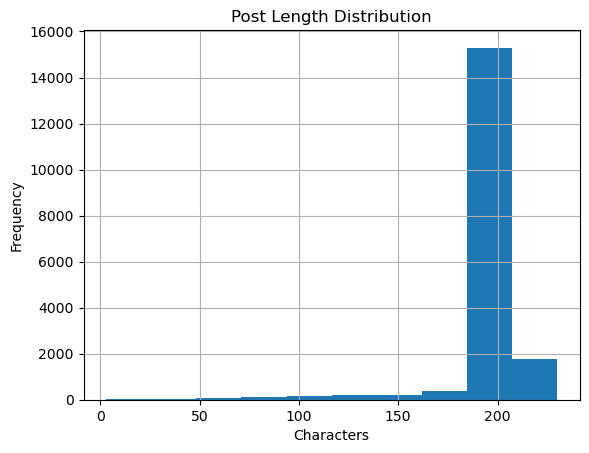

In [79]:
df_beyondblue['post_length'] = df_beyondblue['post_content_preview'].str.len()

df_beyondblue['post_length'].hist(bins=10)
plt.title("Post Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


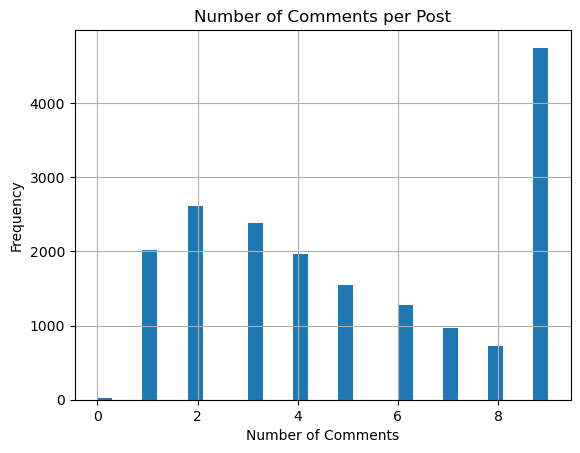

In [80]:
df_beyondblue['num_comments'].hist(bins=30)
plt.title("Number of Comments per Post")
plt.xlabel("Number of Comments")
plt.ylabel("Frequency")
plt.show()


/var/folders/x7/xrth4_p955x331lrb98xvffh0000gn/T/ipykernel_9785/3706255347.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


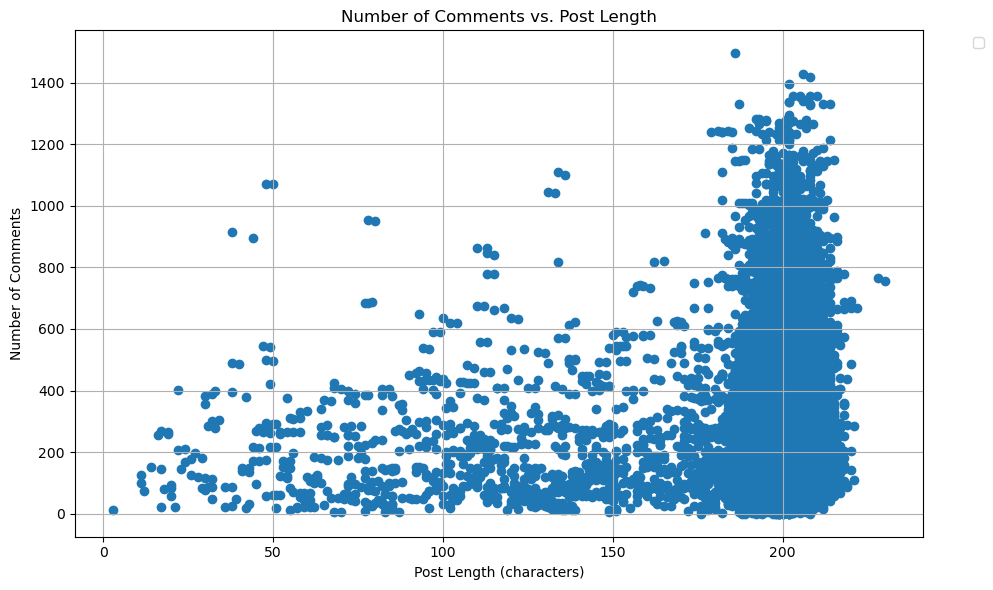

In [81]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_beyondblue['post_length'], df_beyondblue['num_comments_length'])

plt.title('Number of Comments vs. Post Length')
plt.xlabel('Post Length (characters)')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.show()



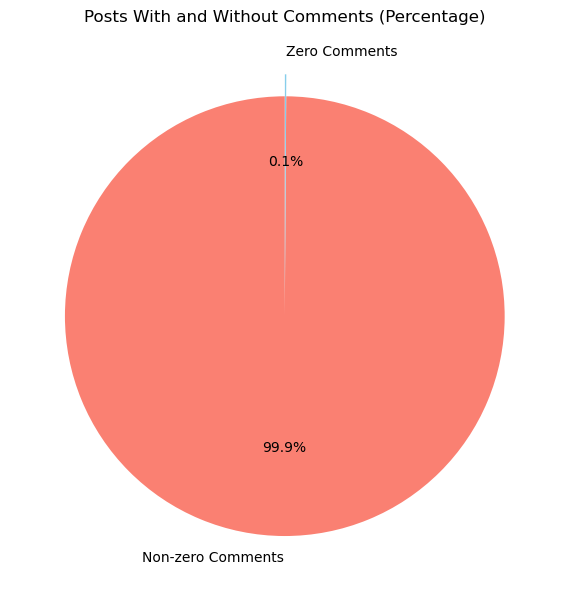

In [82]:
# Pie chart for posts with zero vs. non-zero comments
summary = df_beyondblue['num_comments'].eq(0).value_counts()
summary.index = ['Non-zero Comments', 'Zero Comments']

plt.figure(figsize=(6, 6))
summary.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['salmon', 'skyblue'],
    startangle=90,
    explode=[0.05, 0.05]
)
plt.ylabel('')
plt.title("Posts With and Without Comments (Percentage)")
plt.tight_layout()
plt.show()


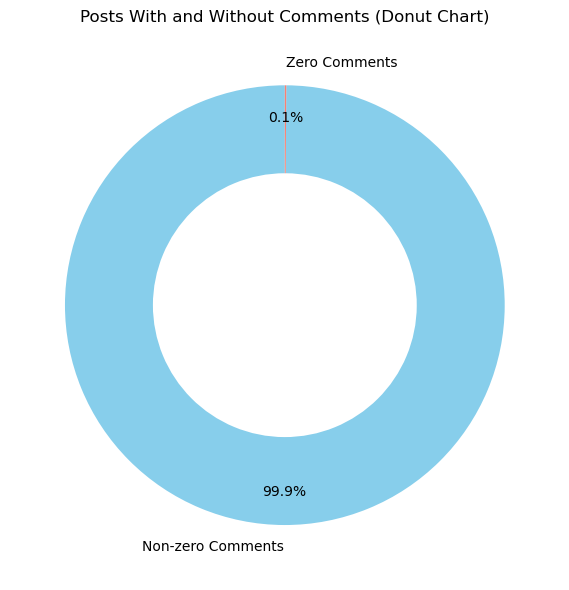

In [83]:
summary = df_beyondblue['num_comments'].eq(0).value_counts()
summary.index = ['Non-zero Comments', 'Zero Comments']

plt.figure(figsize=(6, 6))
summary.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],  # match Reddit colors
    startangle=90,
    wedgeprops=dict(width=0.4),  # makes donut
    pctdistance=0.85             # move % text inside ring
)
plt.ylabel('')
plt.title("Posts With and Without Comments (Donut Chart)")
plt.tight_layout()
plt.show()


In [84]:
import spacy
from tqdm import tqdm

nlp_beyondblue = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def spacy_lemmatize(text):
    if pd.isna(text) or not text:
        return []
    doc = nlp_beyondblue(text)
    return [token.lemma_ for token in doc if not token.is_space and not token.is_stop and not token.is_punct]

df_beyondblue['post_text_lemmas'] = [
    " ".join(spacy_lemmatize(text)) for text in tqdm(df_beyondblue['post_content_preview_clean'], desc="Lemmatizing posts")
]
df_beyondblue['comments_lemma'] = [
    " ".join(spacy_lemmatize(text)) for text in tqdm(df_beyondblue['comments_clean'], desc="Lemmatizing comments")
]


Lemmatizing comments: 100%|██████████| 18266/18266 [08:28<00:00, 35.93it/s]


In [85]:
df_beyondblue

keyword                               post_content_preview  \
0           anxiety  Hi my name is Michelle and I have hadAnxietymy...   
1           anxiety  Hi,   I’ve suffered on and off fromanxietyover...   
3           anxiety  I have had chronicanxietysince 2016, but I hav...   
4           anxiety  Hello I struggle with very badanxietyand panic...   
5           anxiety  I’ve recently sold my mortgage free home that ...   
...             ...                                                ...   
18393  staying well  ...an I help my wife? Can I help me? Can I hel...   
18394  staying well  Hey everyone, hope someone can give me an outs...   
18395  staying well  ...ost of my time has just been spent watching...   
18396  staying well  As the saying goes "life begins at 60" \n Sinc...   
18397  staying well  ...hird child. This has been a decision I have...   

                                              thread_url    post_date  \
0      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎23-05-2025   
1      https://forums.beyondblue.org.au/t5/welcome-an...  ‎28-05-2025   
3      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎06-01-2025   
4      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎04-03-2025   
5      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎04-06-2025   
...                                                  ...          ...   
18393  https://forums.beyondblue.org.au/t5/long-term-...  ‎03-06-2016   
18394  https://forums.beyondblue.org.au/t5/young-peop...  ‎09-01-2018   
18395  https://forums.beyondblue.org.au/t5/young-peop...  ‎31-03-2017   
18396  https://forums.beyondblue.org.au/t5/staying-we...  ‎08-11-2017   
18397  https://forums.beyondblue.org.au/t5/anxiety/an...  ‎24-04-2022   

                                                comments  num_comments  \
0      ["Dear Michelle ~Welcome here to the Support F...             2   
1      ['Hello new member and welcome to the forum.Pl...             4   
3      ['Dear Guest-65543263,I can very much relate t...             9   
4      ['Hello any advice please would help', "Hi don...             4   
5      ["Hi KCT welcomeAnxiety is a serious condition...             3   
...                                                  ...           ...   
18393  Hi, Unfortunately Im not experienced enough to...             9   
18394  Hi Spl spl, I cannot say I have come across th...             9   
18395  Dear Nxrza, Welcom to the Forum, I think there...             9   
18396  hi Meercat , absolutely, for me it has greatly...             9   
18397  hello and welcome. wouldn't it be nice to be a...             7   

                              post_content_preview_clean  \
0      michelle hadanxietymy life usually able contro...   
1      suffered fromanxietyover life recent years rea...   
3      chronicanxietysince managed bay medicationexer...   
4      struggle badanxietyand panic attacks finally g...   
5      recently sold mortgage free home lived years c...   
...                                                  ...   
18393               wife really late tell thanks reading   
18394  hey hope outside perspective pretty root anxie...   
18395  ost spent watching pass fallen touch world hap...   
18396  saying goes life begins turning recently iv wo...   
18397  hird child decision battled withe years yrs ha...   

                                          comments_clean  post_length  \
0      dear michelle welcome good step anxiety coped ...          200   
1      new member welcome forumplease arrived place n...          173   
3      dear guest relate written perimenopause sympto...          186   
4      advice ashamed struggle tell struggling helps ...          197   
5      kct welcomeanxiety condition underestimated po...          192   
...                                                  ...          ...   
18393  unfortunately experienced relationship think l...          136   
18394  spl spl complaining messages little different

In [86]:
# number of posts with each keyword
keywords = df_beyondblue['keyword'].unique()
keyword_counts = df_beyondblue['keyword'].value_counts()
plt.figure(figsize=(12, 6))
# CREATE A DATAFRAME FOR THE KEYWORDS AND THEIR COUNTS
keyword_df = pd.DataFrame({
    'Keyword': keyword_counts.index,
    'Count': keyword_counts.values
})
keyword_df

Keyword  Count
0      people like me   1903
1             anxiety   1754
2        panic attack   1712
3          depression   1701
4      social anxiety   1647
5                PTSD   1497
6                 OCD   1334
7          loneliness   1296
8              trauma   1280
9        staying well   1270
10          self harm   1259
11  Suicidal thoughts    926
12  suicidal thoughts    687

<Figure size 1200x600 with 0 Axes>

In [87]:
# Extract month and year from 'post_date' column
df_beyondblue['post_month'] = df_beyondblue['post_date'].str.extract(r'\d{2}-(\d{2})-\d{4}')
df_beyondblue['post_year'] = df_beyondblue['post_date'].str.extract(r'\d{2}-\d{2}-(\d{4})')

post_year
2011       1
2012       8
2013     403
2014     970
2015    1005
2016    1282
2017    1612
2018    1591
2019    1823
2020    1934
2021    2037
2022    1833
2023    1582
2024    1536
2025     649
Name: count, dtype: int64


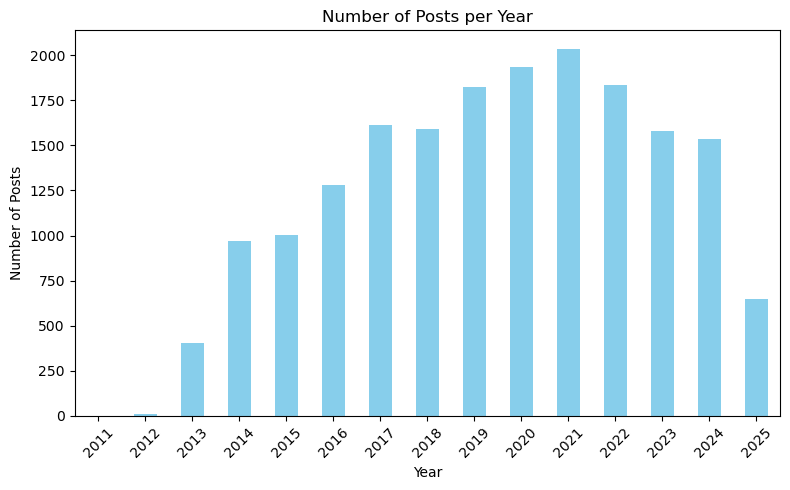

In [88]:
# Count number of posts per year
year_counts = df_beyondblue['post_year'].value_counts().sort_index()

# Display as a table
print(year_counts)

# Optional: Plot
plt.figure(figsize=(8,5))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Posts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

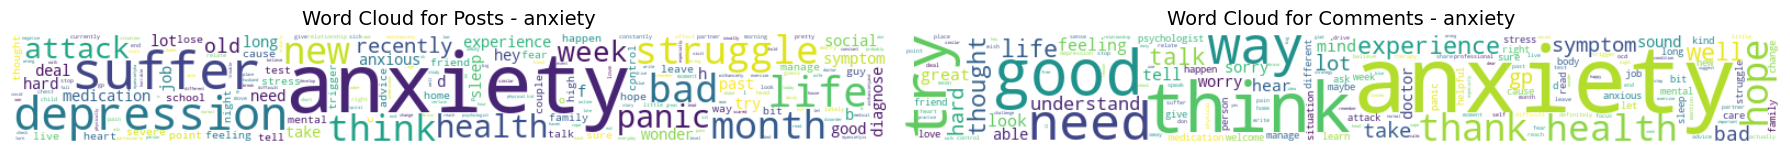

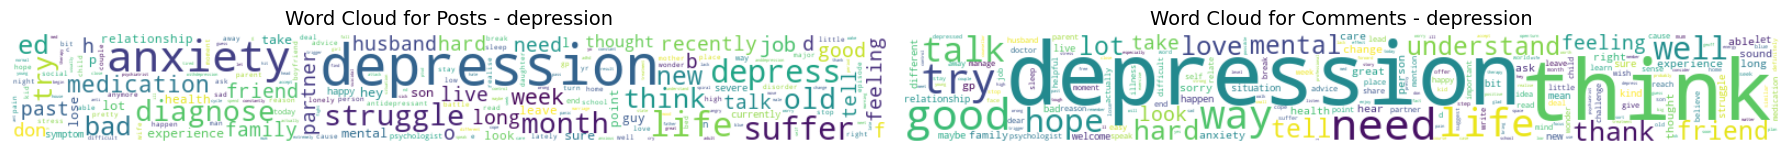

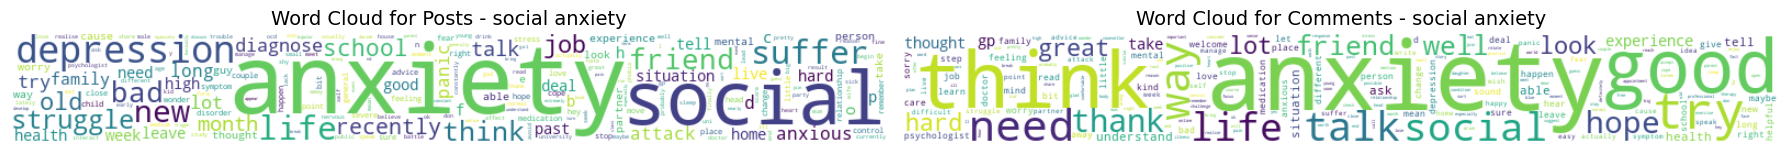

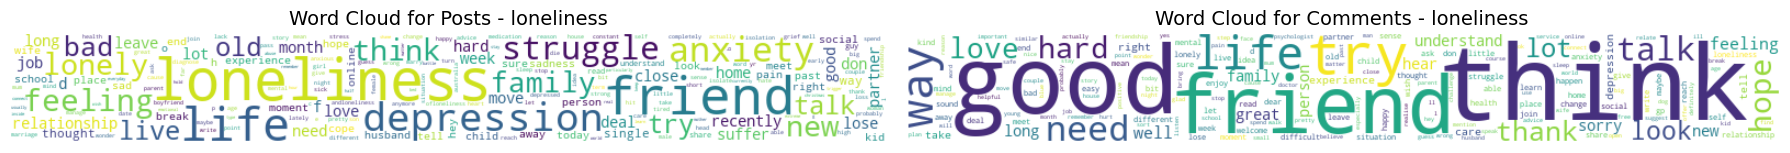

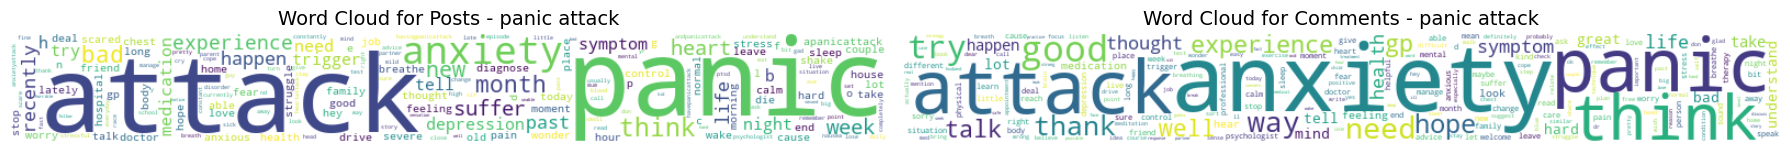

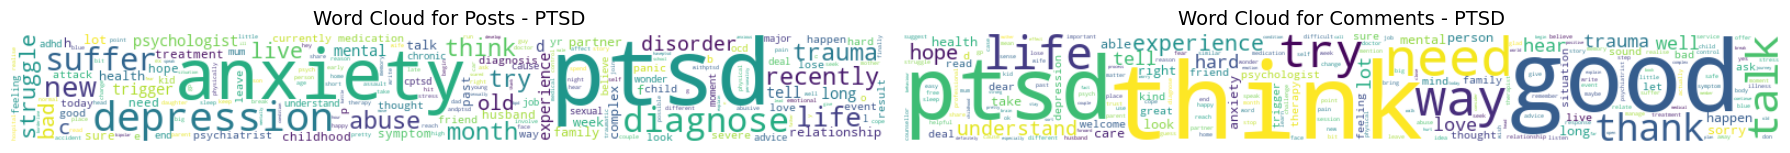

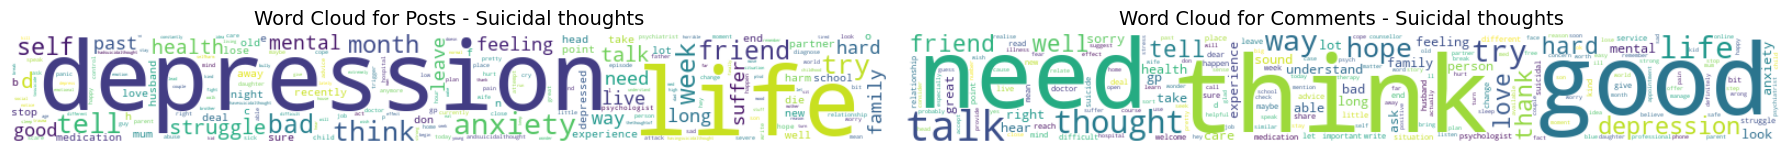

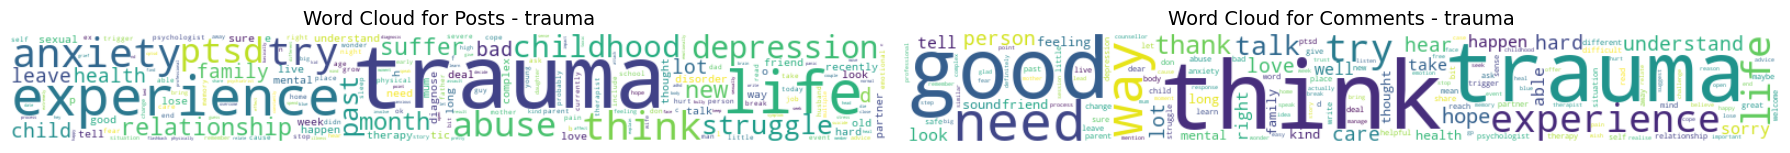

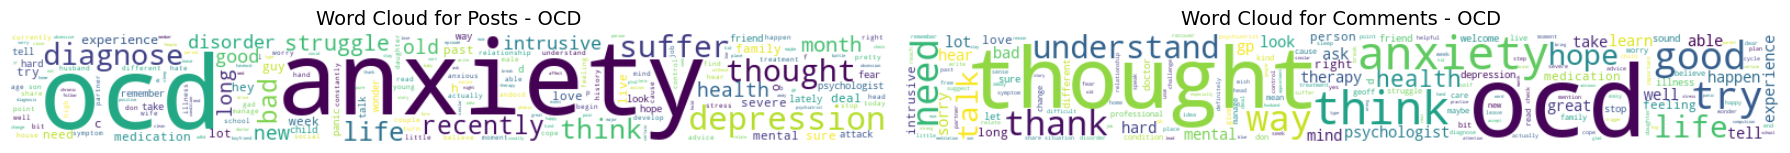

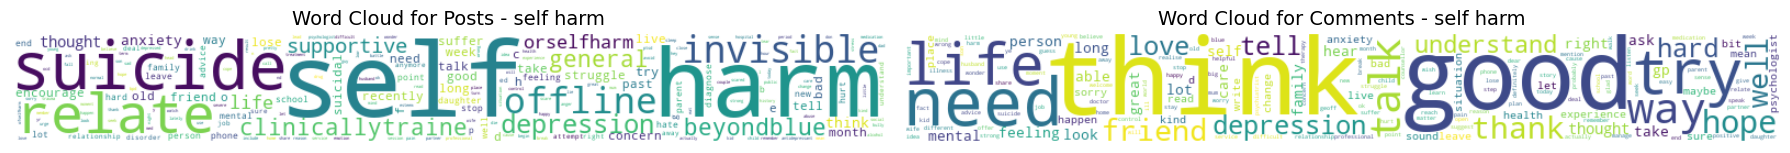

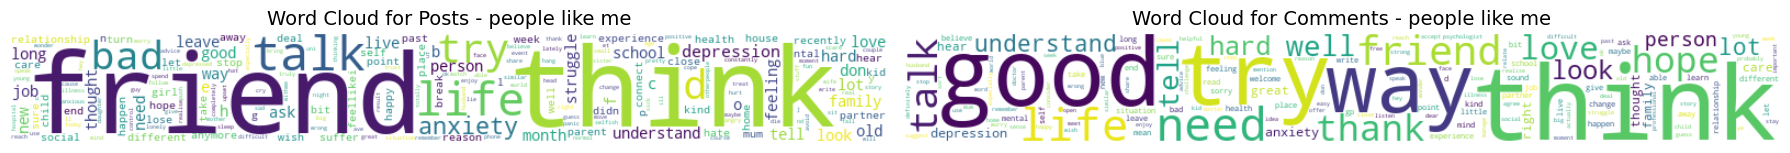

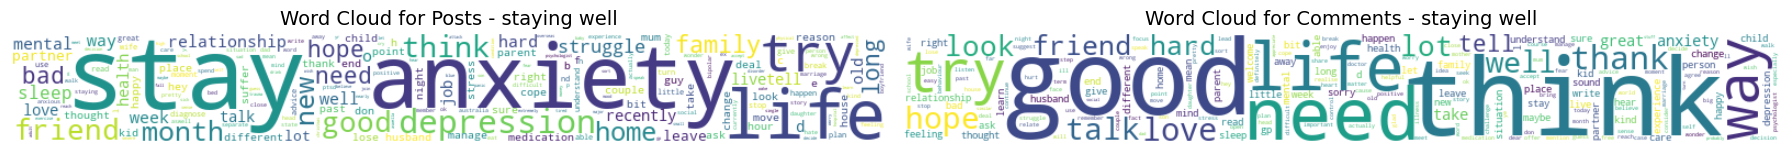

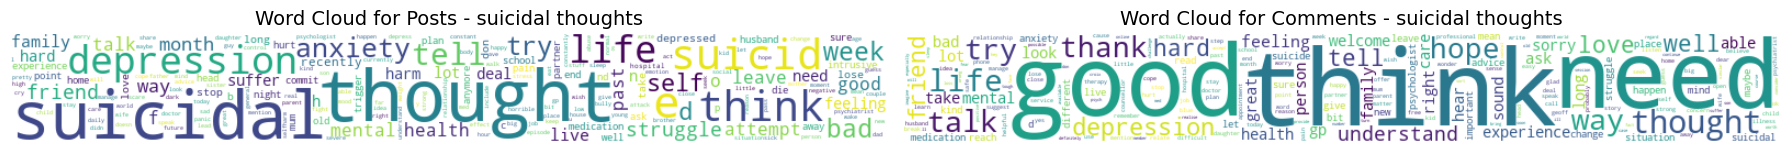

In [89]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine default and custom stopwords
all_stopwords = set(STOPWORDS).union(custom_stopwords)

# Word cloud generator
def generate_wordcloud_pair(post_text, comment_text, keyword):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    wc_post = WordCloud(width=800, height=100, background_color='white',
                        stopwords=all_stopwords, collocations=False).generate(post_text)
    wc_comment = WordCloud(width=800, height=100, background_color='white',
                           stopwords=all_stopwords, collocations=False).generate(comment_text)
    
    axes[0].imshow(wc_post, interpolation='bilinear')
    axes[0].axis("off")
    axes[0].set_title(f"Word Cloud for Posts - {keyword}", fontsize=14)

    axes[1].imshow(wc_comment, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title(f"Word Cloud for Comments - {keyword}", fontsize=14)

    plt.tight_layout()
    plt.show()

# Loop through each unique keyword
for kw in df_beyondblue['keyword'].unique():
    post_text = " ".join(df_beyondblue[df_beyondblue['keyword'] == kw]['post_text_lemmas'])
    comment_text = " ".join(df_beyondblue[df_beyondblue['keyword'] == kw]['comments_lemma'])
    generate_wordcloud_pair(post_text, comment_text, kw)

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


In [91]:
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]


In [92]:
# Use only posts from a specific keyword if needed:
# anxiety_posts = df_beyondblue[df_beyondblue['keyword'] == 'anxiety']['post_text_lemmas']

# Apply on all cleaned post text
top_bigrams = get_top_ngrams(df_beyondblue['post_text_lemmas'], ngram_range=(2, 2), n=15)
top_trigrams = get_top_ngrams(df_beyondblue['post_text_lemmas'], ngram_range=(3, 3), n=15)


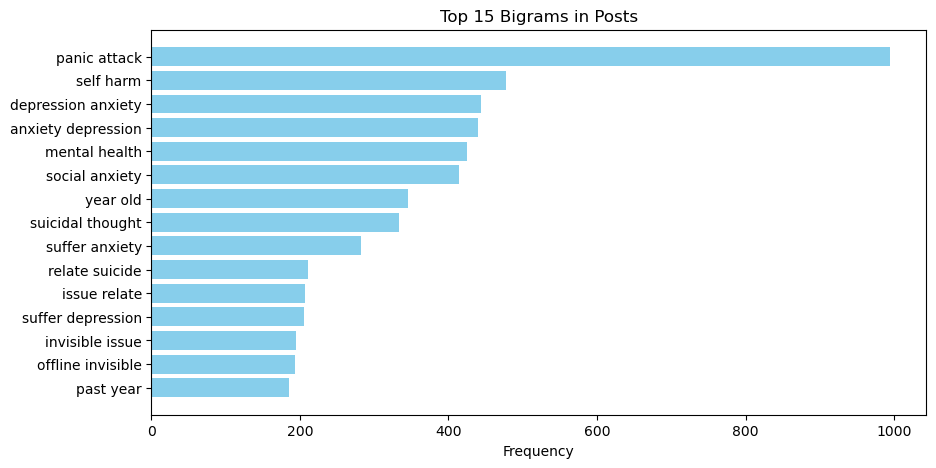

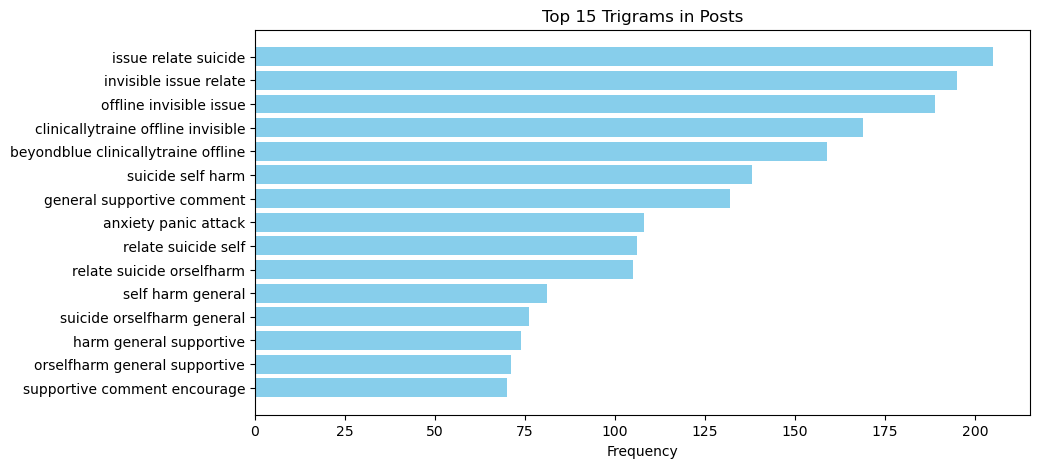

In [93]:
def plot_ngrams(ngrams, title):
    labels, values = zip(*ngrams)
    plt.figure(figsize=(10,5))
    plt.barh(labels[::-1], values[::-1], color='skyblue')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

plot_ngrams(top_bigrams, "Top 15 Bigrams in Posts")
plot_ngrams(top_trigrams, "Top 15 Trigrams in Posts")


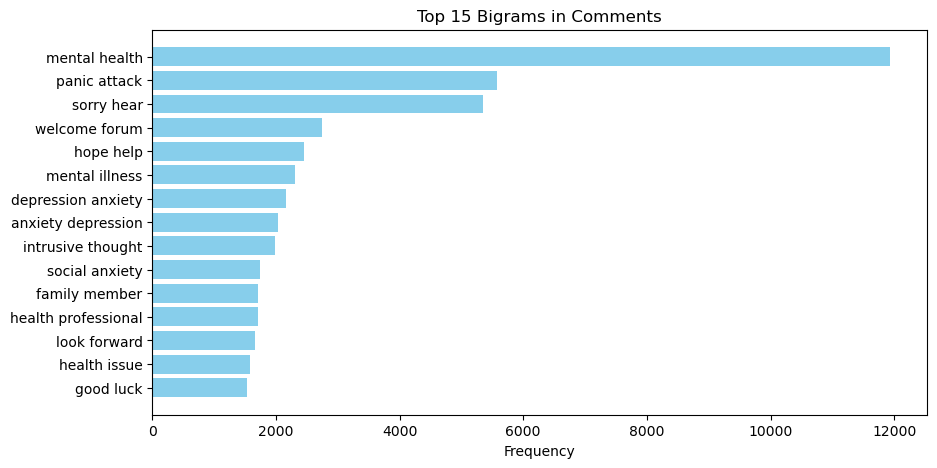

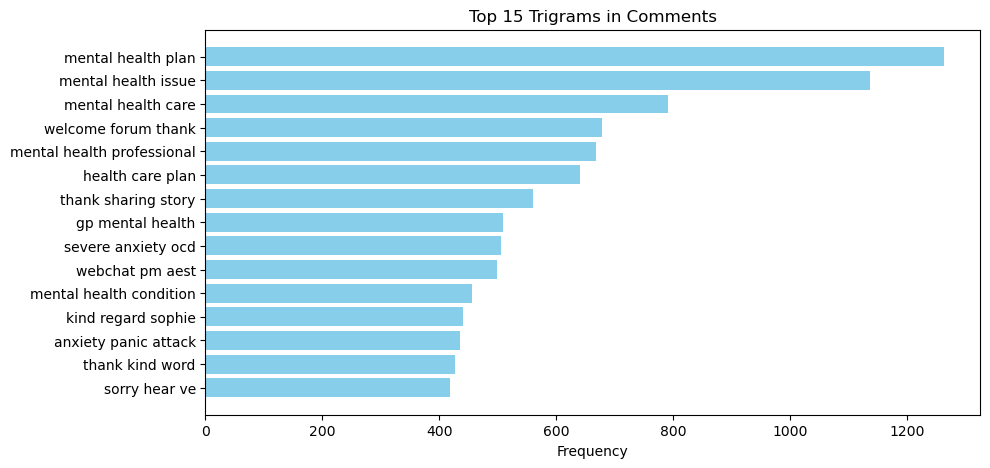

In [94]:
top_comment_bigrams = get_top_ngrams(df_beyondblue['comments_lemma'], ngram_range=(2, 2), n=15)
top_comment_trigrams=get_top_ngrams(df_beyondblue['comments_lemma'],ngram_range=(3,3), n=15)
plot_ngrams(top_comment_bigrams, "Top 15 Bigrams in Comments")
plot_ngrams(top_comment_trigrams,"Top 15 Trigrams in Comments")


In [95]:
df_beyondblue

keyword                               post_content_preview  \
0           anxiety  Hi my name is Michelle and I have hadAnxietymy...   
1           anxiety  Hi,   I’ve suffered on and off fromanxietyover...   
3           anxiety  I have had chronicanxietysince 2016, but I hav...   
4           anxiety  Hello I struggle with very badanxietyand panic...   
5           anxiety  I’ve recently sold my mortgage free home that ...   
...             ...                                                ...   
18393  staying well  ...an I help my wife? Can I help me? Can I hel...   
18394  staying well  Hey everyone, hope someone can give me an outs...   
18395  staying well  ...ost of my time has just been spent watching...   
18396  staying well  As the saying goes "life begins at 60" \n Sinc...   
18397  staying well  ...hird child. This has been a decision I have...   

                                              thread_url    post_date  \
0      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎23-05-2025   
1      https://forums.beyondblue.org.au/t5/welcome-an...  ‎28-05-2025   
3      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎06-01-2025   
4      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎04-03-2025   
5      https://forums.beyondblue.org.au/t5/anxiety/an...  ‎04-06-2025   
...                                                  ...          ...   
18393  https://forums.beyondblue.org.au/t5/long-term-...  ‎03-06-2016   
18394  https://forums.beyondblue.org.au/t5/young-peop...  ‎09-01-2018   
18395  https://forums.beyondblue.org.au/t5/young-peop...  ‎31-03-2017   
18396  https://forums.beyondblue.org.au/t5/staying-we...  ‎08-11-2017   
18397  https://forums.beyondblue.org.au/t5/anxiety/an...  ‎24-04-2022   

                                                comments  num_comments  \
0      ["Dear Michelle ~Welcome here to the Support F...             2   
1      ['Hello new member and welcome to the forum.Pl...             4   
3      ['Dear Guest-65543263,I can very much relate t...             9   
4      ['Hello any advice please would help', "Hi don...             4   
5      ["Hi KCT welcomeAnxiety is a serious condition...             3   
...                                                  ...           ...   
18393  Hi, Unfortunately Im not experienced enough to...             9   
18394  Hi Spl spl, I cannot say I have come across th...             9   
18395  Dear Nxrza, Welcom to the Forum, I think there...             9   
18396  hi Meercat , absolutely, for me it has greatly...             9   
18397  hello and welcome. wouldn't it be nice to be a...             7   

                              post_content_preview_clean  \
0      michelle hadanxietymy life usually able contro...   
1      suffered fromanxietyover life recent years rea...   
3      chronicanxietysince managed bay medicationexer...   
4      struggle badanxietyand panic attacks finally g...   
5      recently sold mortgage free home lived years c...   
...                                                  ...   
18393               wife really late tell thanks reading   
18394  hey hope outside perspective pretty root anxie...   
18395  ost spent watching pass fallen touch world hap...   
18396  saying goes life begins turning recently iv wo...   
18397  hird child decision battled withe years yrs ha...   

                                          comments_clean  post_length  \
0      dear michelle welcome good step anxiety coped ...          200   
1      new member welcome forumplease arrived place n...          173   
3      dear guest relate written perimenopause sympto...          186   
4      advice ashamed struggle tell struggling helps ...          197   
5      kct welcomeanxiety condition underestimated po...          192   
...                                                  ...          ...   
18393  unfortunately experienced relationship think l...          136   
18394  spl spl complaining messages little different

/var/folders/x7/xrth4_p955x331lrb98xvffh0000gn/T/ipykernel_9785/3984760969.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_severity = df_beyondblue.groupby('year_month').apply(


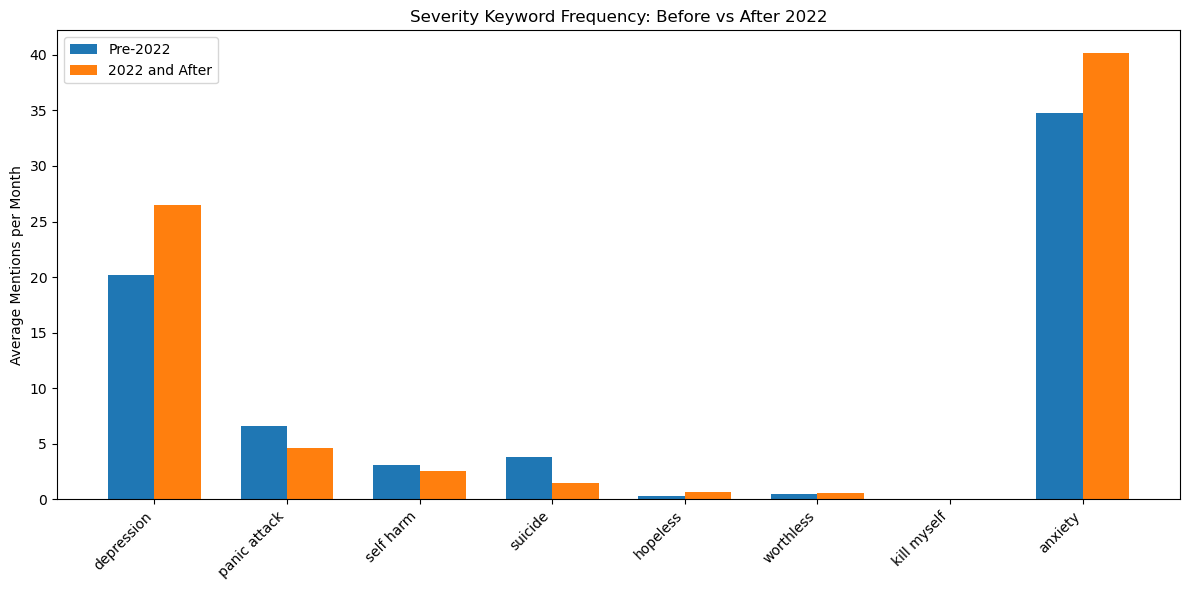

In [96]:

#Step 1: Define severity keywords (lemmatized form)
severity_keywords = ['depression', 'panic attack', 'self harm', 'suicide', 'hopeless', 'worthless', 'kill myself','anxiety']

# Step 2: Create datetime from year and month
df_beyondblue['year_month'] = pd.to_datetime(df_beyondblue['post_year'].astype(str) + '-' + df_beyondblue['post_month'].astype(str) + '-01')

# Step 3: Count keywords using post_text_lemmas
monthly_severity = df_beyondblue.groupby('year_month').apply(
    lambda group: pd.Series({
        keyword: group['post_text_lemmas'].str.contains(keyword, case=False).sum()
        for keyword in severity_keywords
    })
)

# Step 4: Split by pre-2022 and post-2022
pre_2022 = monthly_severity[monthly_severity.index < '2022-01-01']
post_2022 = monthly_severity[monthly_severity.index >= '2022-01-01']

# Step 5: Calculate average mentions
avg_pre = pre_2022.mean()
avg_post = post_2022.mean()

# Step 6: Plotting
labels = avg_pre.index
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, avg_pre.values, width, label='Pre-2022')
ax.bar(x + width/2, avg_post.values, width, label='2022 and After')

ax.set_ylabel("Average Mentions per Month")
ax.set_title("Severity Keyword Frequency: Before vs After 2022")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [97]:
import pandas as pd
import re

# -----------------------------
# 1️⃣ Define severity keywords
# -----------------------------
severity_keywords = {
    "high": [
        "suicide", "kill myself", "want to die", "self harm", "end my life",
        "overdose", "cutting", "hang myself", "can't go on", "ending it all",
        "kill me", "take my life"
    ],
    "moderate": [
        "panic attack", "can't cope", "severe anxiety", "desperate", 
        "hopeless", "worthless", "crying all day", "mental breakdown",
        "no one cares", "giving up"
    ],
    "low": [
        "feeling down", "sad", "stressed", "lonely", "not okay", "tired of life",
        "empty", "anxious", "scared", "lost", "hard time"
    ]
}

# Assign scores
severity_scores = {
    "high": 3,
    "moderate": 2,
    "low": 1
}

# -----------------------------
# 2️⃣ Preprocess text
# -----------------------------
def preprocess_text(text):
    """Lowercase, remove special characters for clean matching."""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.strip()

# -----------------------------
# 3️⃣ Calculate severity score
# -----------------------------
def classify_severity(text):
    text = preprocess_text(text)
    score = 0

    # Count occurrences of keywords in each severity level
    for level, words in severity_keywords.items():
        for word in words:
            if word in text:
                score += severity_scores[level]
    
    # Final classification thresholds
    if score >= 3:
        return "High"
    elif 2 <= score < 3:
        return "Moderate"
    elif 1 <= score < 2:
        return "Low"
    else:
        return "Normal"

# -----------------------------
# 4️⃣ Apply to Beyond Blue posts
# -----------------------------
# Assuming df_beyondblue['post_content_preview_clean'] has cleaned post text
df_beyondblue['severity_level'] = df_beyondblue['post_content_preview_clean'].apply(classify_severity)

# -----------------------------
# 5️⃣ Check results
# -----------------------------
severity_counts = df_beyondblue['severity_level'].value_counts()
print("Severity Level Distribution:\n", severity_counts)

# ✅ df_beyondblue is now updated in memory, no CSV is created


Severity Level Distribution:
 severity_level
Normal      14680
Low          1430
Moderate     1182
High          974
Name: count, dtype: int64


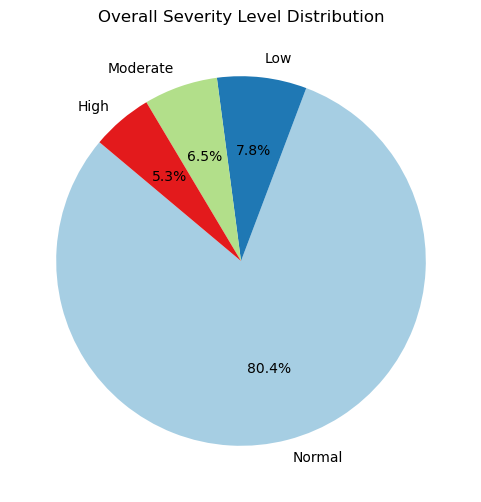

In [98]:
import matplotlib.pyplot as plt

# 1️⃣ Pie Chart – Severity Level Distribution
plt.figure(figsize=(6, 6))
plt.pie(severity_counts, labels=severity_counts.index, autopct='%1.1f%%',
    startangle=140, colors=['#a6cee3','#1f78b4','#b2df8a','#e31a1c'])
plt.title('Overall Severity Level Distribution')
plt.show()



In [99]:
!pip install vaderSentiment


In [100]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sample: load your Beyond Blue DataFrame
# df_beyondblue = pd.read_csv("beyondblue_combined_with_comments_timestamp.csv")

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()


# Function to check keyword severity
def keyword_severity(text):
    text_lower = str(text).lower()
    for word in severity_keywords["high"]:
        if word in text_lower:
            return "high"
    for word in severity_keywords["moderate"]:
        if word in text_lower:
            return "moderate"
    return "normal"

# Combined severity function
def combined_severity(text):
    # Keyword severity
    kw_sev = keyword_severity(text)

    # Sentiment analysis
    scores = analyzer.polarity_scores(str(text))
    compound = scores['compound']

    # Decision rules
    if kw_sev == "high":
        return "High"
    elif kw_sev == "moderate":
        if compound <= -0.5:
            return "High"
        else:
            return "Moderate"
    else:  # keyword severity normal
        if compound <= -0.6:
            return "High"
        elif compound <= -0.3:
            return "Moderate"
        else:
            return "Normal"

# Apply to post text (only posts, not comments)
df_beyondblue['severity_level'] = df_beyondblue['post_content_preview'].apply(combined_severity)

# Check distribution
print(df_beyondblue['severity_level'].value_counts())

# Peek results
print(df_beyondblue[['post_content_preview', 'severity_level']].head())


severity_level
Normal      7966
High        7190
Moderate    3110
Name: count, dtype: int64
                                post_content_preview severity_level
0  Hi my name is Michelle and I have hadAnxietymy...         Normal
1  Hi,   I’ve suffered on and off fromanxietyover...       Moderate
3  I have had chronicanxietysince 2016, but I hav...         Normal
4  Hello I struggle with very badanxietyand panic...       Moderate
5  I’ve recently sold my mortgage free home that ...       Moderate


/var/folders/x7/xrth4_p955x331lrb98xvffh0000gn/T/ipykernel_9785/97908367.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


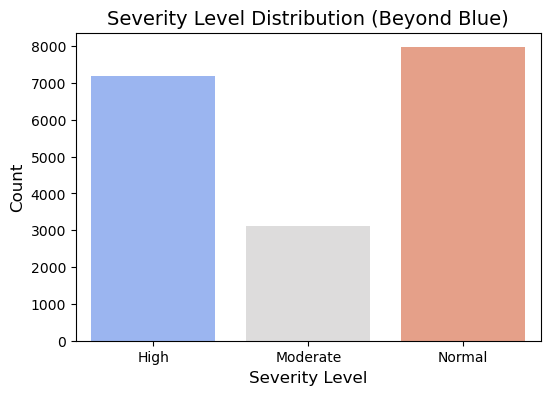

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(
    x='severity_level', 
    data=df_beyondblue, 
    order=['High', 'Moderate', 'Normal'], 
    palette='coolwarm'
)
plt.title('Severity Level Distribution (Beyond Blue)', fontsize=14)
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


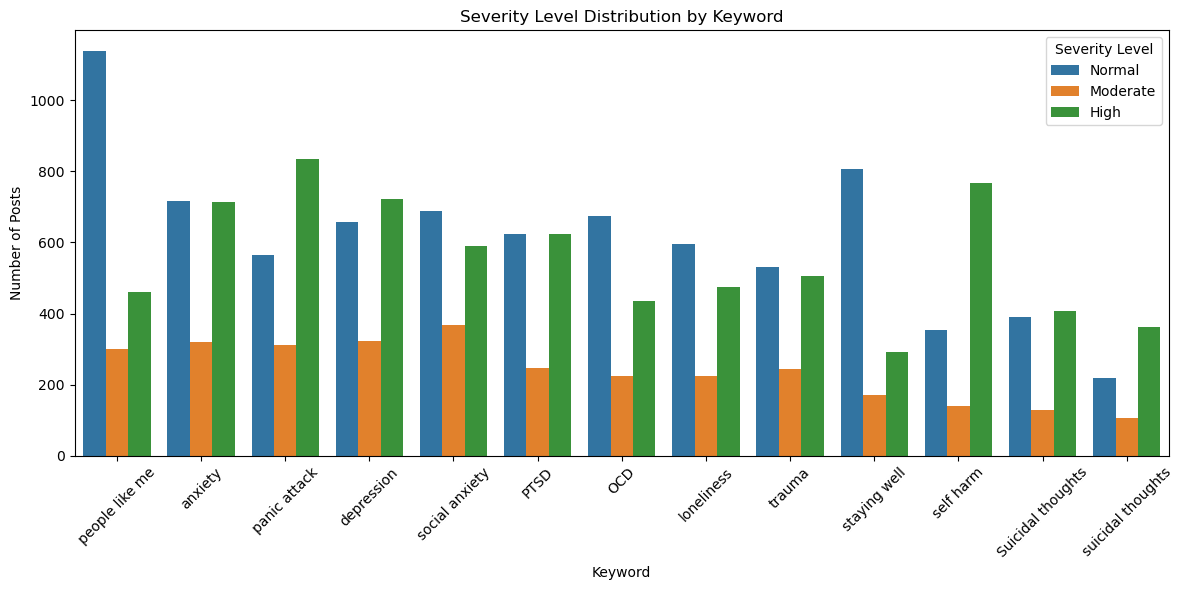

In [102]:
#visualize sentiment by keyword
plt.figure(figsize=(12, 6))
sns.countplot(data=df_beyondblue, x='keyword', hue='severity_level', order=df_beyondblue['keyword'].value_counts().index)
plt.title('Severity Level Distribution by Keyword')
plt.xlabel('Keyword')
plt.ylabel('Number of Posts')
plt.legend(title='Severity Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()